<a href="https://colab.research.google.com/github/syedayazsa/Bird-Species-Detection/blob/main/BirdSpeciesDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.applications import Xception
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

# Downloading and Unzipping the Dataset

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Q8KOOD6KN39mZf4DBG0cHTL96Xk2mM0Z' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Q8KOOD6KN39mZf4DBG0cHTL96Xk2mM0Z" -O data.zip && rm -rf /tmp/cookies.txt

--2021-01-29 15:53:51--  https://docs.google.com/uc?export=download&confirm=WWjT&id=1Q8KOOD6KN39mZf4DBG0cHTL96Xk2mM0Z
Resolving docs.google.com (docs.google.com)... 142.250.73.206, 2607:f8b0:4004:829::200e
Connecting to docs.google.com (docs.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-90-docs.googleusercontent.com/docs/securesc/bk3cs77glhf7c91pajc8v8b7n48b43ig/jgu21iiui5in2b7624cgct60rsrbbhl5/1611935625000/06740098574178032018/09259268110472902902Z/1Q8KOOD6KN39mZf4DBG0cHTL96Xk2mM0Z?e=download [following]
--2021-01-29 15:53:51--  https://doc-0c-90-docs.googleusercontent.com/docs/securesc/bk3cs77glhf7c91pajc8v8b7n48b43ig/jgu21iiui5in2b7624cgct60rsrbbhl5/1611935625000/06740098574178032018/09259268110472902902Z/1Q8KOOD6KN39mZf4DBG0cHTL96Xk2mM0Z?e=download
Resolving doc-0c-90-docs.googleusercontent.com (doc-0c-90-docs.googleusercontent.com)... 172.217.13.225, 2607:f8b0:4004:809::2001
Connecting to doc-0

In [ ]:
!unzip '/content/data.zip'

# Specifying Directory Path

In [4]:
from glob import glob
base_path = '/content/'
folders = glob('train/*')
print(len(folders))

225


In [5]:
IMAGE_SIZE = [299, 299]

train_path = 'train/'
valid_path = 'valid/'

# Preparing the Pre-trained Model

In [6]:
Xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in Xception.layers:
  layer.trainable = False

In [7]:
x = Flatten()(Xception.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [8]:
model_Xception = Model(inputs=Xception.input, outputs=prediction)
model_Xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
opt = Adam(lr=0.00005)

model_Xception.compile(
  loss='categorical_crossentropy',
  optimizer= opt,
  metrics=['accuracy']
)

# Preprocessing the Images

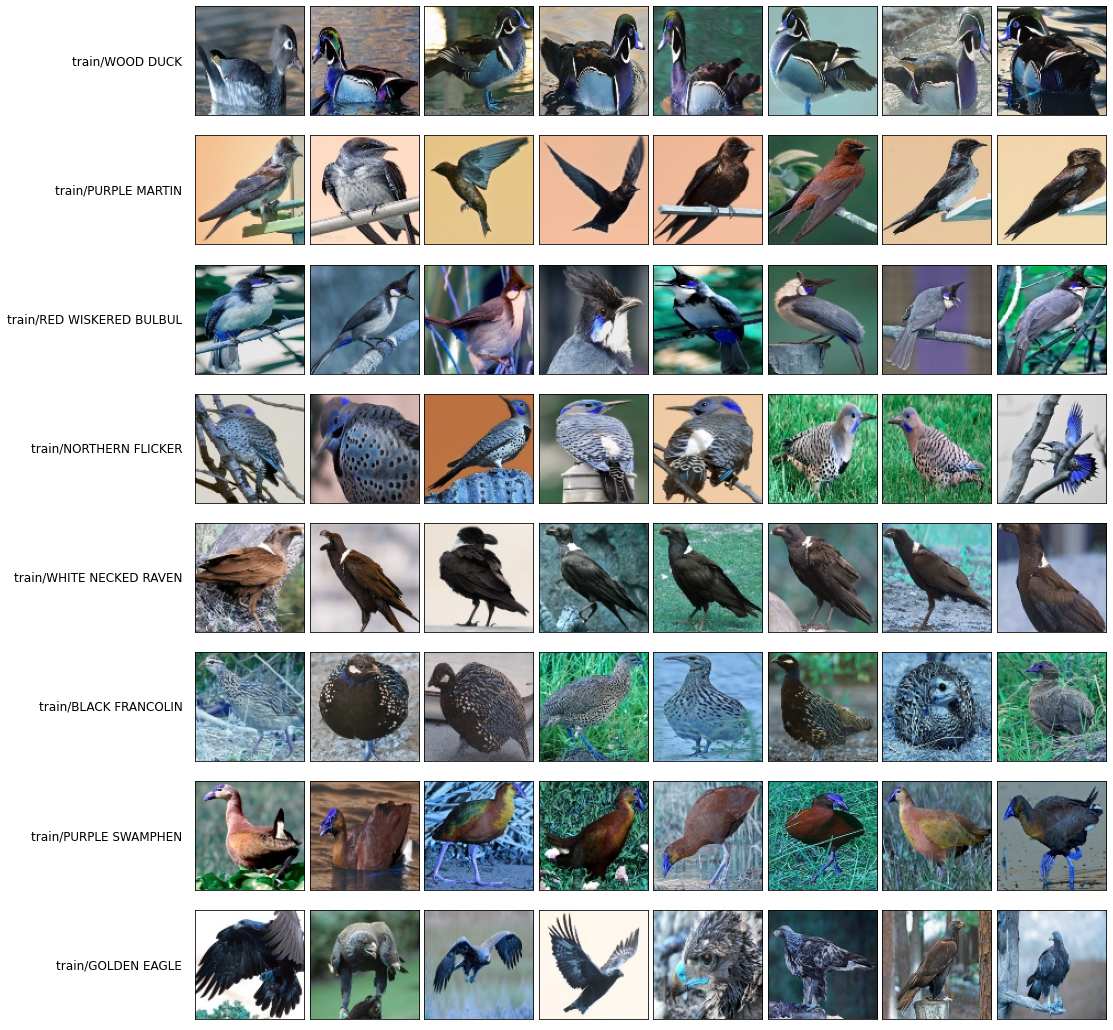

In [32]:
import cv2

categories_selected = folders[0:8]
images_number = 8



fig, ax = plt.subplots(nrows=8, ncols=8)
fig.set_size_inches(15.5, 14.5)

fig.subplots_adjust(wspace=0.1,hspace=0.1)

for i, category in enumerate(categories_selected):
    folder_path = folders[i]
    # take the first objects
    image_names = [img for img in sorted(os.listdir(folder_path))][:images_number]
    
    for j, image_name in enumerate(image_names):
        image_path = folder_path + '/' + image_name
        image = cv2.imread(image_path)
        image = cv2.resize(image, (100, 100)) 
        ax[i,j].imshow(image)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
        if j == 0:
            pad = 5
            ax[i,j].annotate(folders[i], xy=(0, 0.5), xytext=(-ax[i,j].yaxis.labelpad - pad, 0),
                xycoords=ax[i,j].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
fig.tight_layout()
fig.show()

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')
validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('train/',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('valid/',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 31316 images belonging to 225 classes.
Found 1125 images belonging to 225 classes.


# Training the Model

In [11]:
history_Xception = model_Xception.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=50,
  verbose = 1,
  steps_per_epoch=150,
  validation_steps=32
  )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
150/150 [==============================] - 114s 707ms/step - loss: 4.7175 - accuracy: 0.1570 - val_loss: 1.9455 - val_accuracy: 0.5742
Epoch 2/50
150/150 [==============================] - 105s 701ms/step - loss: 2.4948 - accuracy: 0.4358 - val_loss: 1.1668 - val_accuracy: 0.7246
Epoch 3/50
150/150 [==============================] - 105s 699ms/step - loss: 1.7724 - accuracy: 0.5689 - val_loss: 0.8013 - val_accuracy: 0.7979
Epoch 4/50
150/150 [==============================] - 105s 696ms/step - loss: 1.4171 - accuracy: 0.6547 - val_loss: 0.5872 - val_accuracy: 0.8613
Epoch 5/50
150/150 [==============================] - 105s 697ms/step - loss: 1.1999 - accuracy: 0.6981 - val_loss: 0.5708 - val_accuracy: 0.8604
Epoch 6/50
150/150 [==============================] - 104s 695ms/step - loss: 1.1027 - accuracy: 0.7280 - val_loss: 0.4753 - val_accuracy: 0.8730
Epoch 7/50
150/150 [==============================] - 104s 694ms/step - loss: 1.0214 - accuracy: 0.7343 - val_loss: 0.4015 -

# Model Testing

In [21]:
datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory('test/', target_size=[299, 299], class_mode='categorical', batch_size=32, shuffle=True)

model_Xception.evaluate(test_data)

Found 1125 images belonging to 225 classes.
36/36 [==============================] - 9s 253ms/step - loss: 0.0891 - accuracy: 0.9724


[0.08914007991552353, 0.9724444150924683]

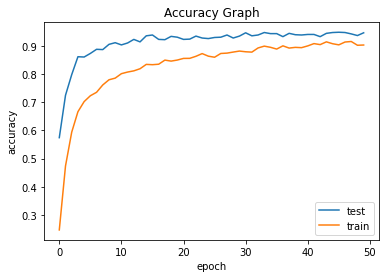

In [12]:
plt.plot(history_Xception.history['val_accuracy'])
plt.plot(history_Xception.history['accuracy'])
plt.title('Accuracy Graph')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['test', 'train'], loc='lower right')
plt.show()

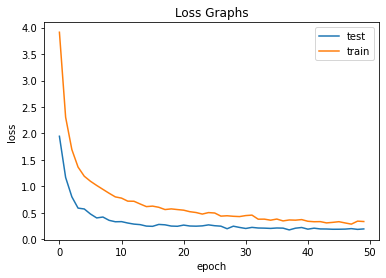

In [13]:
plt.plot(history_Xception.history['val_loss'])
plt.plot(history_Xception.history['loss'])
plt.title('Loss Graphs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['test', 'train'], loc='upper right')
plt.show()

# Saving the Model

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
model_Xception.save('/content/gdrive/My Drive/Model/BirdSpecies_Xception.h5')